In [84]:
import warnings
warnings.filterwarnings("ignore")
import re
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
sys.path.append(os.path.abspath('..'))
from model.data_loader import Dataset

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# tf.debugging.set_log_device_placement(True)
# tf.autograph.set_verbosity(3, True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
training_data_dir = "../data/train/"
os.listdir(training_data_dir)

['healthy_wheat', 'leaf_rust', 'stem_rust']

In [86]:
data = Dataset(filepath=training_data_dir,
               batch_size=64,
               train_test_split=0.9,
               augment=False)
N, C, H, W = data.batch_size, data.channel, data.height, data.width

876
['healthy_wheat' 'leaf_rust' 'stem_rust'] (3,)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Mangled names are not yet supported by AutoGraph
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Mangled names are not yet supported by AutoGraph
Tensor("strided_slice:0", shape=(), dtype=string)
all: 876, train: 788, val: 87


In [87]:
np.array([item.name for item in Path(training_data_dir).glob('*')])

print(len([name for name in os.listdir(training_data_dir+"leaf_rust") if os.path.isfile(os.path.join(training_data_dir+"leaf_rust", name))]))

358


In [88]:
for image, label in data.val.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy().shape)

Image shape:  (64, 224, 224, 3)
Label:  (64, 3)


In [89]:
batch_size, height, width, channel = data.batch_size, data.height, data.width, data.channel
CLASS_NAMES = data.class_names
IMG_SHAPE = (height, width, channel)

In [90]:
def show_batch(img, label):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(img[n])
        plt.title(CLASS_NAMES[label[n] == 1][0].title())
        plt.axis('off')

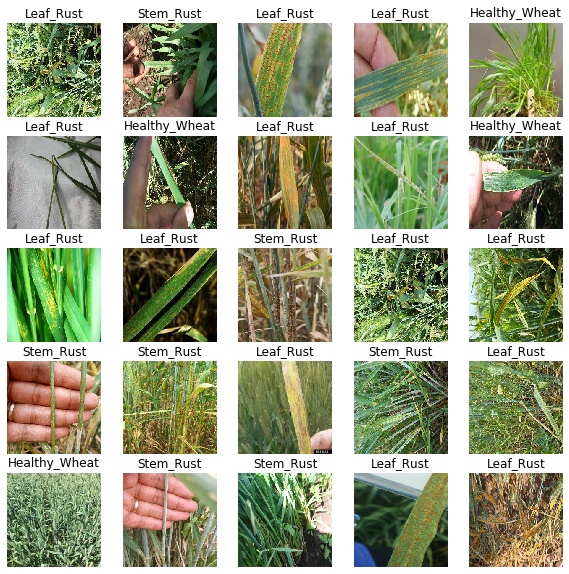

In [91]:
image_batch, label_batch = next(iter(data.train))
show_batch(image_batch.numpy(), label_batch.numpy())

In [108]:
# define class weights
leaf_rust_count = len([name for name in os.listdir(training_data_dir+"leaf_rust") if os.path.isfile(os.path.join(training_data_dir+"leaf_rust", name))])
stem_rust_count = len([name for name in os.listdir(training_data_dir+"stem_rust") if os.path.isfile(os.path.join(training_data_dir+"stem_rust", name))])
healthy_wheat_count = len([name for name in os.listdir(training_data_dir+"healthy_wheat") if os.path.isfile(os.path.join(training_data_dir+"healthy_wheat", name))])
total = leaf_rust_count + stem_rust_count + healthy_wheat_count

# leaf_rust_weight = (1/leaf_rust_count) * (total) / 3.0
# stem_rust_weight = (1/stem_rust_count) * (total) / 3.0
# healthy_wheat_weight = (1/healthy_wheat_count) * (total) / 3.0

leaf_rust_weight = leaf_rust_count / total
stem_rust_weight = stem_rust_count / total
healthy_wheat_weight = healthy_wheat_count / total


class_weight = {0:leaf_rust_weight, 1:stem_rust_weight, 2:healthy_wheat_weight}
print(class_weight)

{0: 0.408675799086758, 1: 0.4292237442922374, 2: 0.16210045662100456}


In [116]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
callbacks = [early_stopping, mcp_save, reduce_lr_loss]

In [117]:
resnet152_base = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
resnet152_base.trainable = False
# fine_tune_at = 100
# resnet152_base.trainable = True
# for layer in resnet152_base.layers[:fine_tune_at]:
#   layer.trainable =  False


model = tf.keras.Sequential([
resnet152_base,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(512, activation="relu"),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(3, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

In [118]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 1539      
Total params: 59,382,275
Trainable params: 1,050,627
Non-trainable params: 58,331,648
_________________________________________________________________


In [119]:
model.fit(data.train,
          epochs=80,
          steps_per_epoch=None,
          validation_data=data.val,
          validation_steps=None,
          class_weight=class_weight,
          callbacks=callbacks)

Train for 13 steps, validate for 2 steps
Epoch 1/80
13/13 [==============================] - 40s 3s/step - loss: 1.2563 - categorical_accuracy: 0.5203 - val_loss: 0.2038 - val_categorical_accuracy: 0.5795
Epoch 2/80
13/13 [==============================] - 29s 2s/step - loss: 0.2583 - categorical_accuracy: 0.5520 - val_loss: 0.2085 - val_categorical_accuracy: 0.5909
Epoch 3/80
13/13 [==============================] - 29s 2s/step - loss: 0.1951 - categorical_accuracy: 0.6371 - val_loss: 0.2512 - val_categorical_accuracy: 0.7386
Epoch 4/80
13/13 [==============================] - 29s 2s/step - loss: 0.1840 - categorical_accuracy: 0.6802 - val_loss: 0.1466 - val_categorical_accuracy: 0.8295
Epoch 5/80
13/13 [==============================] - 28s 2s/step - loss: 0.1528 - categorical_accuracy: 0.7386 - val_loss: 0.1674 - val_categorical_accuracy: 0.8636
Epoch 6/80
13/13 [==============================] - 29s 2s/step - loss: 0.1424 - categorical_accuracy: 0.7982 - val_loss: 0.2731 - val_cate

In [120]:
model.load_weights(".mdl_wts.hdf5")

In [121]:
test_list = "../data/test"
test_list_ds = tf.data.Dataset.list_files(str(test_list +'*/*'))
# for f in test_list_ds.take(5):
#   print(f.numpy())

def process_test(img_path):
    img_loader = tf.io.read_file(img_path)
    img_decoder = tf.image.decode_jpeg(img_loader, channels=C)
    img = tf.image.convert_image_dtype(img_decoder, tf.float32)
    img = tf.image.resize(img, [W, H])
    return img, img_path
    
test_ds = test_list_ds.map(process_test, num_parallel_calls=24)#.batch(128)

test_count = len(list(Path(test_list).glob('*')))
print(test_count)

610


In [122]:
names = []
preds = []

for i, j in tqdm(test_ds):
    i = i.numpy()[np.newaxis, :] # add a new dimension
    prediction = model.predict_proba(i) # make predictions
    preds.append(prediction) 
    
    # use regular expressions to extract the name of image
    name = j.numpy()
    name = re.sub("[^A-Z0-9]", "", str(name))
    name = name.replace("JPG", "")
    name = name.replace("PNG", "")
    name = name.replace("JPEG", "")
    name = name.replace("JFIF", "")
    names.append(name)

610it [00:44, 13.73it/s]


In [123]:
preds[:5]

[array([[0.28330004, 0.41174713, 0.3049528 ]], dtype=float32),
 array([[1.7301047e-06, 9.9844068e-01, 1.5575385e-03]], dtype=float32),
 array([[0.15361746, 0.25435576, 0.5920268 ]], dtype=float32),
 array([[0.02141139, 0.816538  , 0.16205066]], dtype=float32),
 array([[0.01242193, 0.8920451 , 0.09553308]], dtype=float32)]

In [124]:
leaf_rust = pd.Series(range(610), name="leaf_rust", dtype=np.float32)
stem_rust = pd.Series(range(610), name="stem_rust", dtype=np.float32)
healthy_wheat = pd.Series(range(610), name="healthy_wheat", dtype=np.float32)
sub = pd.concat([leaf_rust, stem_rust, healthy_wheat], axis=1)
print(sub.shape)

for i in tqdm(range(0 ,len(preds))):
    sub.loc[i] = preds[i]
    # break
sub['ID'] = names
cols = sub.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub = sub[cols]
sub.head()

100%|██████████| 610/610 [00:00<00:00, 11949.86it/s](610, 3)



,ID,leaf_rust,stem_rust,healthy_wheat
0,L2JR4M,0.283300,0.411747,0.304953
1,FKPU4K,0.000002,0.998441,0.001558
2,EY1RVI,0.153617,0.254356,0.592027
3,84FZDZ,0.021411,0.816538,0.162051
4,RHJXWS,0.012422,0.892045,0.095533


In [125]:
sub.to_csv("../submissions/xfer.csv", index=False)

In [101]:
np.sum(preds)

610.0

In [102]:
asdf = model.predict_proba(test_ds, batch_size=None)# steps=None)#, batch_size=610)

ValueError: in converted code:

    C:\Users\Han\Miniconda3\envs\tf21\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py:677 map_fn
        batch_size=None)
    C:\Users\Han\Miniconda3\envs\tf21\lib\site-packages\tensorflow_core\python\keras\engine\training.py:2410 _standardize_tensors
        exception_prefix='input')
    C:\Users\Han\Miniconda3\envs\tf21\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected resnet152v2_input to have 4 dimensions, but got array with shape (224, 224, 3)


In [ ]:
asdf.shape

In [ ]:
a, b = next(iter(test_ds))

In [ ]:
b

In [ ]:
asdf[0]

In [ ]:
import os
submission = pd.DataFrame({'ID': [s.split('.')[0] for s in os.listdir('../data/test') if s.split('.')[1] != 'jfif']})
for i, c in enumerate(test_ds):
  submission[c] = preds_test[:,i]
submission = submission[['ID', 'leaf_rust', 'stem_rust', 'healthy_wheat']] # Get same order as sample sub
submission.head()